<a href="https://colab.research.google.com/github/bksgupta/course-v3/blob/master/lesson4_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/movie_lens_sample/ratings.csv')]

In [6]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [7]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [8]:
y_range = [0,5.5]

In [9]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.608963,0.954934,00:00
1,0.848888,0.673404,00:00
2,0.652664,0.668255,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [13]:
path=Config.data_path()/'ml-100k'

In [14]:
!mv '/content/ml-100k.zip' {Config.data_path()}

In [17]:
Config.data_path().ls()

[PosixPath('/root/.fastai/data/ml-100k'),
 PosixPath('/root/.fastai/data/movie_lens_sample.tgz'),
 PosixPath('/root/.fastai/data/ml-100k.zip'),
 PosixPath('/root/.fastai/data/movie_lens_sample')]

In [16]:
!unzip {Config.data_path()}/'ml-100k.zip' -d {Config.data_path()}

Archive:  /root/.fastai/data/ml-100k.zip
   creating: /root/.fastai/data/ml-100k/
  inflating: /root/.fastai/data/ml-100k/allbut.pl  
  inflating: /root/.fastai/data/ml-100k/mku.sh  
  inflating: /root/.fastai/data/ml-100k/README  
  inflating: /root/.fastai/data/ml-100k/u.data  
  inflating: /root/.fastai/data/ml-100k/u.genre  
  inflating: /root/.fastai/data/ml-100k/u.info  
  inflating: /root/.fastai/data/ml-100k/u.item  
  inflating: /root/.fastai/data/ml-100k/u.occupation  
  inflating: /root/.fastai/data/ml-100k/u.user  
  inflating: /root/.fastai/data/ml-100k/u1.base  
  inflating: /root/.fastai/data/ml-100k/u1.test  
  inflating: /root/.fastai/data/ml-100k/u2.base  
  inflating: /root/.fastai/data/ml-100k/u2.test  
  inflating: /root/.fastai/data/ml-100k/u3.base  
  inflating: /root/.fastai/data/ml-100k/u3.test  
  inflating: /root/.fastai/data/ml-100k/u4.base  
  inflating: /root/.fastai/data/ml-100k/u4.test  
  inflating: /root/.fastai/data/ml-100k/u5.base  
  inflating: /roo

In [24]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [25]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [26]:
len(ratings)

100000

In [27]:
len(movies)

1682

In [28]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [29]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [30]:
data.show_batch()

userId,title,target
886,Star Trek: Generations (1994),3.0
123,Raging Bull (1980),5.0
889,Swimming with Sharks (1995),2.0
843,Raising Arizona (1987),3.0
794,Alice in Wonderland (1951),4.0


In [31]:
y_range = [0,5.5]

In [32]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


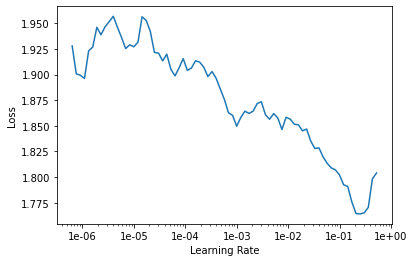

In [33]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [34]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.922334,0.941209,00:09
1,0.863931,0.886625,00:09
2,0.752314,0.835937,00:09
3,0.650411,0.813978,00:09
4,0.561200,0.812356,00:09


In [35]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [36]:
learn.load('dotprod');

In [37]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [38]:
rating_movie[rating_movie[title]=='Star Wars (1977)']

,userId,movieId,rating,timestamp,title
50711,290,50,5,880473582,Star Wars (1977)
50712,79,50,4,891271545,Star Wars (1977)
50713,2,50,5,888552084,Star Wars (1977)
50714,8,50,5,879362124,Star Wars (1977)
50715,274,50,5,878944679,Star Wars (1977)
...,...,...,...,...,...
51289,749,50,5,878846978,Star Wars (1977)
51290,886,50,5,876031501,Star Wars (1977)
51291,739,50,4,886958895,Star Wars (1977)
51292,903,50,5,891031329,Star Wars (1977)


In [42]:
# g = rating_movie.groupby(title)['userId'].count()
# g.loc['Star Wars (1977)']

583

In [43]:
g = rating_movie.groupby(title)['rating'].count()
# g = rating_movie.groupby(title)
# g.index.values
# g[g[title]=='Star Wars (1977)']
# g.head()
top_movies = g.sort_values(ascending=False).index.values[:1000]
# top_movies = g.sort_values(ascending=False)
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [47]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [48]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [49]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3385),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3179),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2870), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2790), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2611), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2564), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2397), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2394), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2294), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2264), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2250), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2238), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.2238), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2212), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0

In [50]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6028), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5999), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5347), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5149), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5145), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5067), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5039), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4830), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4817), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4714), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4673), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4631), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4512), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4506), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4466), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667)]

### Movie weights

In [51]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [52]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [53]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [57]:
fac0.shape

torch.Size([1000])

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1630), 'Wrong Trousers, The (1993)'),
 (tensor(1.1300), 'Close Shave, A (1995)'),
 (tensor(1.0794), 'Casablanca (1942)'),
 (tensor(1.0774), 'Chinatown (1974)'),
 (tensor(0.9993), 'When We Were Kings (1996)'),
 (tensor(0.9884), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9883), 'Lawrence of Arabia (1962)'),
 (tensor(0.9791), 'Third Man, The (1949)'),
 (tensor(0.9739), 'Godfather, The (1972)'),
 (tensor(0.9368), 'Secrets & Lies (1996)')]

In [59]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3831), 'Home Alone 3 (1997)'),
 (tensor(-1.2428), "McHale's Navy (1997)"),
 (tensor(-1.2360), 'Jungle2Jungle (1997)'),
 (tensor(-1.2224), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.2010), 'Leave It to Beaver (1997)'),
 (tensor(-1.1009), 'Batman & Robin (1997)'),
 (tensor(-1.0886), 'Congo (1995)'),
 (tensor(-1.0761), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0669), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0336), 'Bio-Dome (1996)')]

In [60]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [61]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2089), 'Braveheart (1995)'),
 (tensor(1.0194), 'Titanic (1997)'),
 (tensor(1.0083), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9450), "It's a Wonderful Life (1946)"),
 (tensor(0.8636), 'Pretty Woman (1990)'),
 (tensor(0.8370), 'American President, The (1995)'),
 (tensor(0.8157), 'Air Force One (1997)'),
 (tensor(0.8097), 'Back to the Future (1985)'),
 (tensor(0.8064), 'Hunt for Red October, The (1990)'),
 (tensor(0.7982), 'Independence Day (ID4) (1996)')]

In [62]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8662), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8345), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.8315), 'Keys to Tulsa (1997)'),
 (tensor(-0.7847), 'Trainspotting (1996)'),
 (tensor(-0.7767), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7670), 'Big Night (1996)'),
 (tensor(-0.7617), 'Brazil (1985)'),
 (tensor(-0.7609), 'Lost Highway (1997)'),
 (tensor(-0.7580), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7539), 'Very Brady Sequel, A (1996)')]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


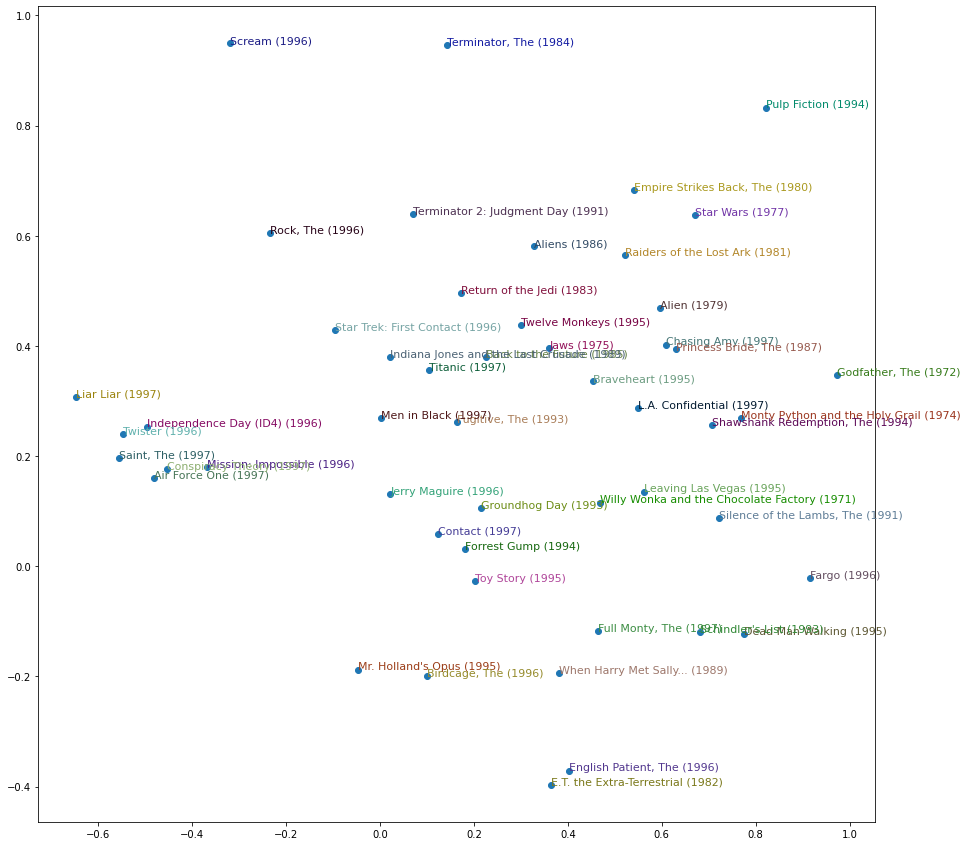

In [63]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
print (idxs)
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()